In [1]:
from lifelong_forests import *

In [2]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def homogenize_labels(a):
    u = np.unique(a)
    return np.array([np.where(u == i)[0][0] for i in a])

In [6]:
train_file = 'cifar-100-python/train'
unpickled_train = unpickle(train_file)
train_keys = list(unpickled_train.keys())
fine_labels = np.array(unpickled_train[train_keys[2]])

train_data = unpickled_train[list(train_keys)[-1]]
class_idx = [np.where(fine_labels == u)[0] for u in np.unique(fine_labels)]

n_tasks = 10 # should divide 100 evenly
K = int(len(class_idx)/n_tasks)

train_by_task = [np.concatenate(class_idx[i*n_tasks: (i+1)*n_tasks]) for i in range(n_tasks)]

n_trees = int(np.sqrt(len(class_idx[0])))

test_file = 'cifar-100-python/test'
unpickled_test = unpickle(test_file)
test_keys = list(unpickled_test.keys())
test_labels = np.array(unpickled_test[test_keys[2]])

test_data = unpickled_test[test_keys[-1]]
test_class_idx = [np.where(test_labels == u)[0] for u in np.unique(test_labels)]
test_by_task = [np.concatenate(test_class_idx[i*n_tasks: (i+1)*n_tasks]) for i in range(n_tasks)]

In [7]:
models = []

for i, u in enumerate(range(n_tasks)):
    X = train_data[np.concatenate(class_idx[i*n_tasks: (i+1)*n_tasks])]
    labels = np.concatenate([n_tasks*i*np.ones(500) + j for j in range(n_tasks*i, n_tasks*(i+1))])
    model = build_model(X, labels, n_trees)
    models.append(model)

In [8]:
# qa_check = np.zeros((n_tasks, 1000, K))
# i = 0
# X = train_data[np.concatenate(class_idx[i*n_tasks: (i+1)*n_tasks])]
# labels = np.concatenate([i*n_tasks*np.ones(500) + j for j in range(n_tasks*i, n_tasks*(i+1))])

# for i in range(qa_check.shape[0]):
#     if i == 0:
#         qa_check[i] = estimate_posteriors(models[i], X, labels, test_data[test_by_task[0]], in_task=True, subsample=0.32)
#     else:
#         qa_check[i] = estimate_posteriors(models[i], X, labels, test_data[test_by_task[0]], in_task=False, subsample=0.32)

# qa_avg = np.mean(qa_check, axis = 0)
# print(qa_avg.shape)
# print(np.sum(predict(qa_avg) == test_labels[test_by_task[0]]) / len(test_by_task[0]))

In [9]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

def estimate_posteriors(model, train, y, test, in_task=True, subsample=1, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)

    n, d = train.shape
    m, d_ = test.shape

    if d != d_:
        raise ValueError("train and test data in different dimensions")

    class_counts = np.zeros((m, model.n_classes_))
    unique_labels = np.unique(y)
    def _map(u, x):
        return np.where(u == x)[0][0]
    
    for tree in model:
        # get out of bag indicies
        if in_task:
            prob_indices = _generate_unsampled_indices(tree.random_state, n)
        else:
            prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)
        
        leaf_nodes = get_leaves(tree)
        unique_leaf_nodes = np.unique(leaf_nodes)
            
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(unique_leaf_nodes), model.n_classes_))

        for prob_index in prob_indices:
            temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
            posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], _map(unique_labels, y[prob_index])] += 1
            
        # total number of points in a node
        row_sums = posterior_class_counts.sum(axis=1)
        
        # no divide by zero
        row_sums[row_sums == 0] = 1

        # posteriors
        class_probs = (posterior_class_counts / row_sums[:, None])
        # posteriors with finite sampling correction
        
        class_probs = finite_sample_correction(class_probs, row_sums)

        # posteriors as a list
        class_probs.tolist()
  
        partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts / class_counts.sum(axis=1, keepdims=True)

    return probs

In [10]:
etas = [np.zeros((i + 1, n_tasks*100, 10)) for i in range(n_tasks)]
subsample=1

for i, test_set in enumerate(test_by_task):
    for j in range(etas[i].shape[0]):
        print(i,j)
        if i == j:
            etas[i][j] = estimate_posteriors(models[i], 
                            train_data[np.array(train_by_task[j])], 
                            fine_labels[np.array(train_by_task[j])],
                            test_data[test_by_task[j]],
                            in_task = True,
                            subsample = subsample)
        else:
            etas[i][j] = estimate_posteriors(models[i], 
                            train_data[train_by_task[j]], 
                            fine_labels[train_by_task[j]],
                            test_data[test_by_task[j]],
                            in_task = False,
                            subsample = subsample)

0 0
1 0
1 1
2 0
2 1
2 2
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
5 5
6 0
6 1
6 2
6 3
6 4
6 5
6 6
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9


In [12]:
# pickle.dump(etas, open('estimated_posteriors.pkl', 'wb'))
# etas_ = pickle.load(open('estimated_posteriors.pkl', 'rb'))
etas_ = etas

In [13]:
average_etas = [np.zeros((i + 1, n_tasks*100, 10)) for i in range(n_tasks)]
for i in range(n_tasks):
    for j in range(average_etas[i].shape[0]):
        average_etas[i][j] = np.mean(np.array([etas_[k][j] for k in range(j, i+1)]), axis=0)

In [14]:
homogenized_labels = [homogenize_labels(test_labels[t]) for t in test_by_task]
accuracies = [np.zeros(i + 1) for i in range(n_tasks)]
for i in range(n_tasks):
    for j in range(average_etas[i].shape[0]):
        accuracies[i][j] = np.sum(predict(average_etas[i][j]) == homogenized_labels[j])/len(homogenized_labels[j])
        
new_accs = []
for i in range(n_tasks):
    temp = np.zeros(n_tasks - i)
    for j in range(i, n_tasks):
        temp[j - i] = accuracies[j][i]
    new_accs.append(temp)

In [15]:
accuracies

[array([0.378]),
 array([0.406, 0.336]),
 array([0.418, 0.336, 0.431]),
 array([0.426, 0.358, 0.425, 0.354]),
 array([0.436, 0.366, 0.442, 0.362, 0.409]),
 array([0.432, 0.373, 0.463, 0.397, 0.43 , 0.39 ]),
 array([0.443, 0.378, 0.465, 0.408, 0.412, 0.404, 0.414]),
 array([0.451, 0.388, 0.469, 0.407, 0.43 , 0.44 , 0.46 , 0.386]),
 array([0.465, 0.393, 0.455, 0.41 , 0.435, 0.449, 0.468, 0.411, 0.35 ]),
 array([0.476, 0.384, 0.464, 0.415, 0.452, 0.468, 0.464, 0.454, 0.377,
        0.417])]

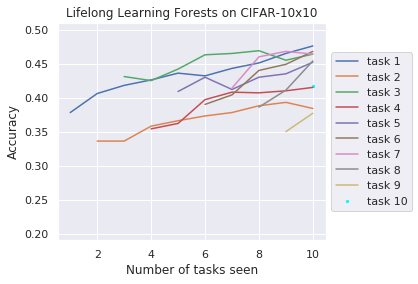

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(1,1)
# c = sns.color_palette('rainbow', n_colors=10)
for i in range(n_tasks - 1):
    ns = np.arange(i + 1, n_tasks + 1)
    ax.plot(ns, new_accs[i], label = 'task %i'%(i + 1))
    
ax.scatter(10, new_accs[-1], c = 'cyan', label='task 10', s = 5)
    
ax.set_title('Lifelong Learning Forests on CIFAR-10x10')
ax.set_xlabel('Number of tasks seen')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.2 - 0.01, 0.5 + 0.01)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend()

plt.savefig('initial-cifar-100-debugged-1-subsample.pdf')